# The No U-Turn Sampler

Hoffman & Gelman 2011: The No U-Turn Sampler
* implement algorithms 1 (basic HMC) & 6 (NUTS with dual averaging)
* test that your implementations work by replicating the following tests in Section 4.1:
 * 250-dimensional Gaussian
 * Bayesian logistic regression & hierarchical Bayesian logistic regression on the UCI german credit data
 * compare the results given by basic HMC & NUTS
 * compare your results with the same models run in Stan using the provided NUTS sampler
  * see e.g. mc-stan.org/users/interfaces/pystan.html

## General notes
Both the No-U-turn sampler and the HMC sampler only return latter half of the sample.
I've aimed at a between 50 and 60 percent acceptance rate for the accepted half.

To avoid variable names overlapping, each part resets the variables.

Functions for checking the convergence:
- ChainMix.py: between- and within chains mixing (BDA3, p. 284, formula 11.3); every chain is splitted into two halves, as the writers suggest in the footnote on p. 285

## Algorithm 1: Basic hamiltonian Monte Carlo
file: HMC.py

## Algorithm 6: Efficient No-U-Turn sampler
file: noUturnSampler.py

_________________________________________________________________
# Test case 0: simple linear regression
First test is a simple linear regression with coefficients alpha=theta[0]=10 and
beta=theta[1]=5. This test is for to roughly see that the sampler works.

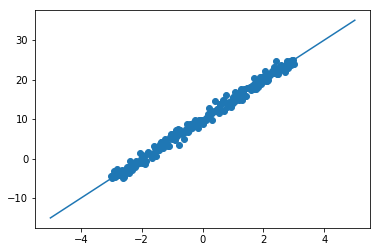

In [15]:
#%reset
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd
import matplotlib.pyplot as plt
import noUturnSampler
import HMC
npr.seed(42)
# Always import the newest version of the samplers
import importlib
importlib.reload(noUturnSampler)
importlib.reload(HMC)

def LikelihoodTest0(theta, x, y, sigma2=1.0):
    return np.sum(-1/(2*sigma2)*(y-theta[0]-theta[1]*x)**2)

test0x=np.linspace(-3, 3, 200)
test0y=10+5*test0x+npr.normal(size=200)
# beta values for data generation are: [10, 5]
plt.scatter(test0x,test0y)
plt.plot(np.linspace(-5,5,200), 10+5*np.linspace(-5,5,200))

SimpleRegression=lambda x: LikelihoodTest0(x, test0x, test0y, sigma2=1.0)

### HMC

All in all accepted:  1000.0 , proportion:  1.0
Accepted:  499.0
Acceptance rate:  0.998
alpha:  9.939950150229771 beta:  5.040532850961048


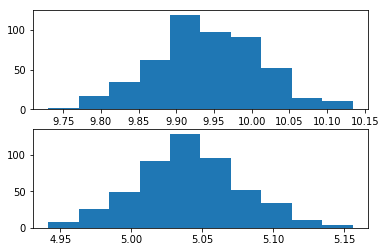

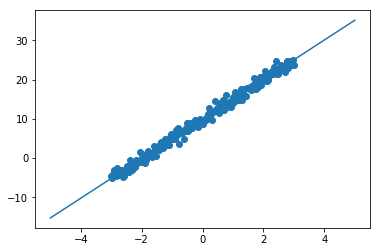

In [16]:
np.seterr('raise')
test0theta, test0r = HMC.basicHmc(np.array([-10.0, -10.0]), 0.001, 40, SimpleRegression, 1000)

print('alpha: ', np.mean(test0theta[:,0]), 'beta: ', np.mean(test0theta[:,1]))
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) # two axes on figure
ax2.hist(test0theta[:, 0])
ax3.hist(test0theta[:,1])

fig3, (plot1) = plt.subplots(nrows=1, ncols=1)
plot1.plot(np.linspace(-5,5,200), np.mean(test0theta[:,0])+np.mean(test0theta[:,1])*np.linspace(-5,5,200))
plt.scatter(test0x, test0y)

### No-U-Turn sampler

U-Turn sampler finished.
Alpha value:  9.960636513775752
Beta value:  5.038450641565703


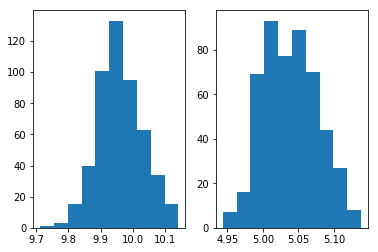

In [19]:
import importlib
importlib.reload(noUturnSampler)

np.seterr('warn')
# def NoUTurn(theta0, delta, fLikelihood, nSamples, nSamplesAdapt)
sample0UTurn, epsilonHist0=noUturnSampler.NoUTurn(np.array([1.0,1.0]), 0.60, SimpleRegression, 1000,500, testRun=False)

fig3, (plot1,plot2) = plt.subplots(nrows=1, ncols=2)
plot1.hist(sample0UTurn[:,0])
plot2.hist(sample0UTurn[:,1])
print('Alpha value: ',np.mean(sample0UTurn[:,0]))
print('Beta value: ', np.mean(sample0UTurn[50:,1]))

____________________________________________________
# Bayesian logistic regression

Metadata from Harvard data verse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/Q8MAW8

Original data from: https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data), using the file "german.data-numeric" version produced by Strathclyde University. Changes made: 
- changed the ordering of Attribute 3 (Credit History) to try to extract monotone relationship: ORIGINAL ORDERING: A30 : no credits taken/all credits paid back duly, A31 : all credits at this bank paid back duly, A32 : existing credits paid back duly till now, A33 : delay in paying off in the past, A34 : critical account/other credits existing (not at this bank)) NEW ORDERING: 0=all credits paid back (A31) 1=all credits paid back duly til now (A32) 2= no credits taken (A30) 3= delay in past (A33) 4=critical acct (A34). 


ATTRIBUTES: 
1 BalanceCheque
2 Loan NurnMonth
3 CreditHistory 
4 CreditAmt 
5 SavingsBalance 
6 Mths in PresentEmployment 
7 PersonStatusSex 
8 PresentResidenceSince 
9 Property 
10 AgeInYears 
11 OtherInstallmentPlans (highest val is NO other installment plans) 
12 NumExistingCreditsThisBank 
13 NumPplLiablMaint 
14 Telephone 
15 ForeignWorker 
16 Purpose-CarNew 
17 Purpose-CarOld 
18 otherdebtor-none (compared to guarantor) 
19 otherdebt-coappl (compared to guarantor) 
20 house-rent (compared to 'for free') 
21 house-owns (compared to 'for free') 
22 job-unemployed (vs mgt) 
23 jobs-unskilled (vs mgt) 
24 job-skilled (vs mgt) 

In [40]:
#%reset
import autograd.numpy as np
import autograd.numpy.random as npr
# Download data and standardize X
# Should have values 1 or -1
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import HMC
import noUturnSampler
import ChainMix
import Neff
import LikelihoodFunctions
#import CovergenceTests
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)
importlib.reload(LikelihoodFunctions)

npr.seed(42)
np.seterr('warn')

credit0= pd.read_csv('dataGerman.tab', delim_whitespace=True)

creditY=np.array(credit0['CREDITRATING'])

creditX0=np.array(credit0.loc[:, credit0.columns != 'CREDITRATING'])
creditX=(creditX0 - np.mean(creditX0, axis=0))/np.std(creditX0, axis=0)

# Solve beta values for comparison
logistic = LogisticRegression(fit_intercept=False)
betaCoefficients=logistic.fit(creditX,creditY).coef_

lBayesLRX=lambda theta0: LikelihoodFunctions.lBayesLR(theta0, creditX, creditY)

C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


## HMC

In [41]:
# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(25)
thetaOriginal2=npr.normal(-10.0, 5.0, 25)
thetaOriginal3=npr.normal(10.0, 5.0, 25)
thetaOriginal4=npr.normal(0.0, 5.0, 25)

# Sample size*2 (only the latter half is returned)
size=5000
hmcTheta0=np.empty([size//2, 25, 4])
hmcTheta0[:,:,0], hmcR1 = HMC.basicHmc(thetaOriginal1, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,1], hmcR2 = HMC.basicHmc(thetaOriginal2, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,2], hmcR3 = HMC.basicHmc(thetaOriginal3, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,3], hmcR4 = HMC.basicHmc(thetaOriginal4, 0.08, 20, lBayesLRX, size)

All in all accepted:  2581.0 , proportion:  0.5162
Accepted:  1275.0
Acceptance rate:  0.51
All in all accepted:  2623.0 , proportion:  0.5246
Accepted:  1330.0
Acceptance rate:  0.532
All in all accepted:  2512.0 , proportion:  0.5024
Accepted:  1242.0
Acceptance rate:  0.4968
All in all accepted:  2645.0 , proportion:  0.529
Accepted:  1353.0
Acceptance rate:  0.5412


### HMC: Chain mixing and effective sample size
RHat statistic describes the relation of between- and within-chain variances. Its value is 1 if the chains are perfectly mixed, but value 1.1 (as mentioned is the lecture notes) is considered to be sufficient as a an indicator for the convergence.

BDA3 suggests that sufficient effective sample size is at least 5m, so that there is at least 10 independent draws per sequence. (p 287)

Here the rHat statistic suggests that chains have converged only for some coefficients. Increasing sample size didn't help the problem.

Effective sample size test is unreliable and should not be considered in any of the test cases.

RHat statistics for the parameters are:  [8.39710013 5.63390623 2.99970145 2.60420658 1.38069026 2.91002692
 1.69758117 1.62898828 1.0060776  1.5463678  1.23283163 2.26995947
 1.52069698 1.02379135 1.42229972 1.82420926 2.30698301 2.29854294
 1.98812279 1.85864309 1.17395658 1.02681264 1.21189769 1.00385583
 1.0007508 ]
vt0 (1250, 25, 8)
tt (1250,)
Effective sample size:  [    4.0540829      4.12519042     4.49191633     4.63811942
     8.27515257     4.53135839     6.09777174     6.35021887
 -1143.4223667      6.73243532    10.92988453     4.97326645
     6.79386147    54.75650144     7.86523907     5.69111766
     4.94478394     4.91969449     5.31314446     5.65210588
    13.83607632    76.20535166    12.46611736   120.99227909
  -843.79618024]


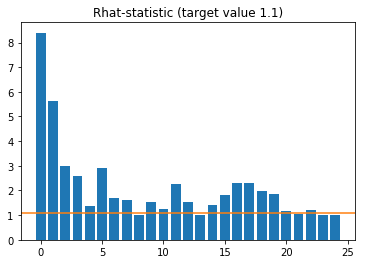

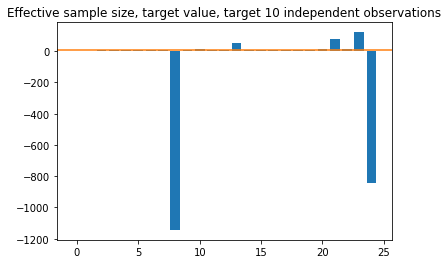

In [45]:
import ConvergenceTests
importlib.reload(ConvergenceTests)
hmcTheta1=ConvergenceTests.ConvergenceTest(hmcTheta0)

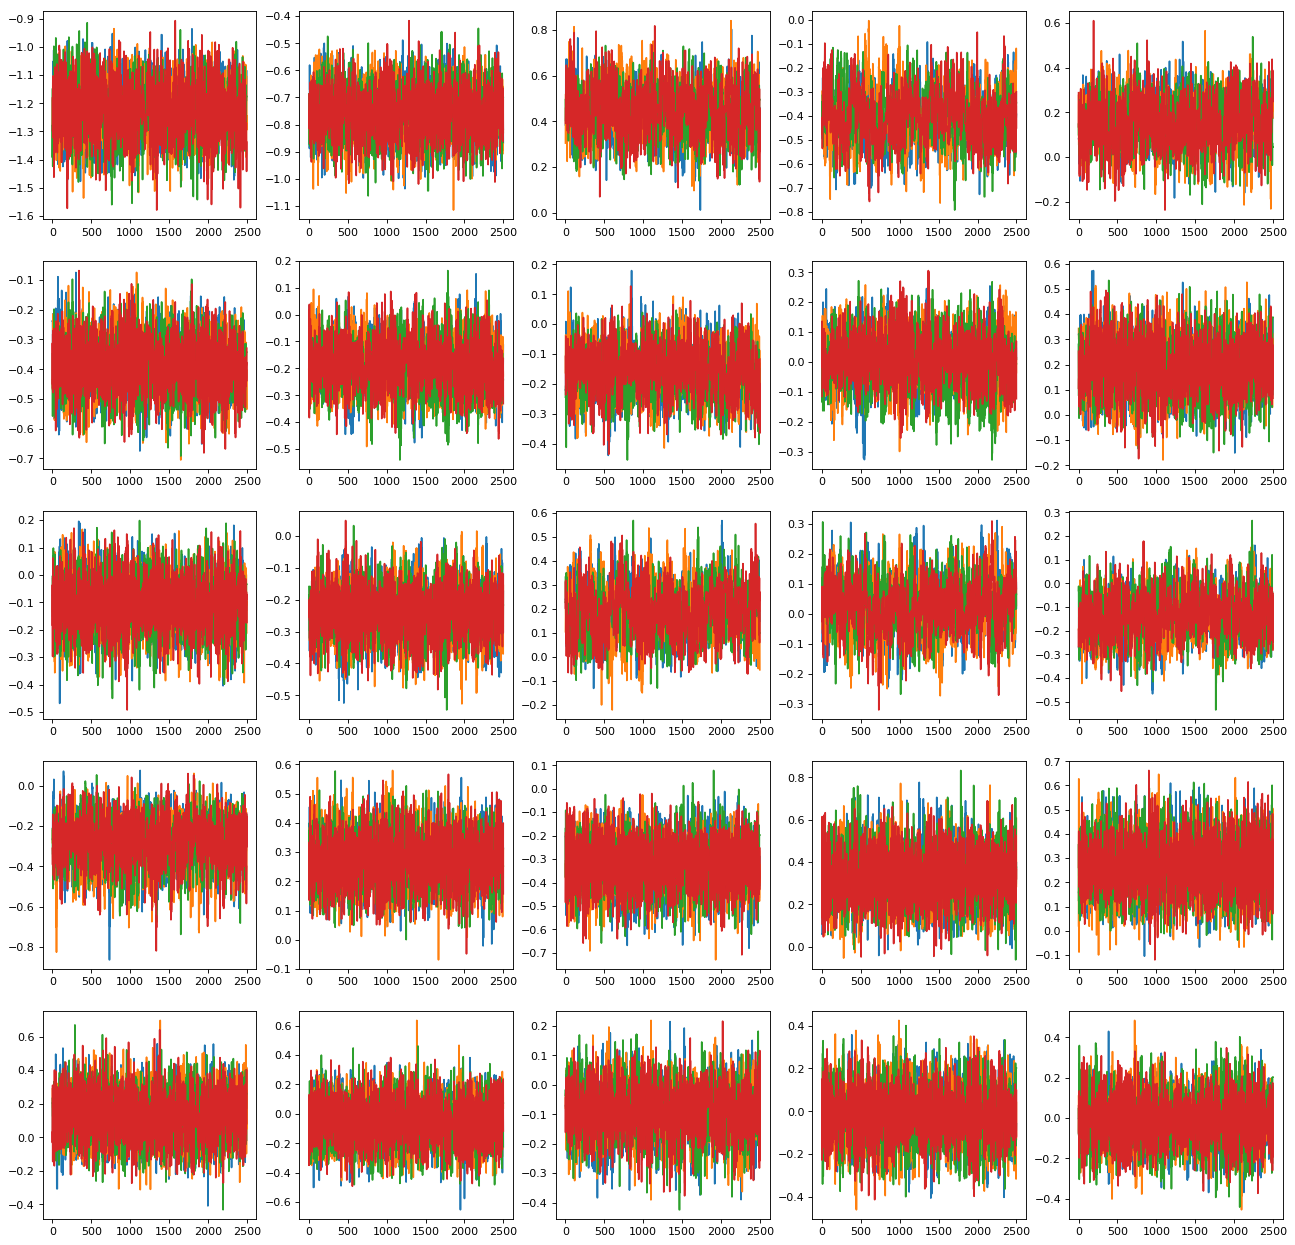

In [43]:
# Plot the 25 samples
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for i in range(hmcTheta0.shape[1]):
    plt.subplot(5,5,i+1)
    plt.plot(hmcTheta0[:, i, :])

### HMC: Comparison with logistic regression coefficients

Logistic regression coefficients (without sampling):  [[-1.16693394 -0.72428117  0.41863996 -0.38950509  0.14971296 -0.36499316
  -0.17983097 -0.15223281  0.0088167   0.17896626 -0.10547967 -0.23223442
   0.1752658   0.02906784 -0.13173154 -0.25096542  0.26151383 -0.3013166
   0.29946551  0.24939256  0.12501634 -0.06082535 -0.08394011 -0.01848919
  -0.00851217]]
sample coefficients:  [-0.76212457 -0.47088436  0.2777147  -0.25144643  0.09437932 -0.23762629
 -0.11719875 -0.09841608  0.0065848   0.11749404 -0.06627458 -0.15092242
  0.11584648  0.01637011 -0.08648359 -0.17546591  0.16983759 -0.2004815
  0.20421926  0.16855796  0.08277253 -0.03290569 -0.05587774 -0.01091374
 -0.00380516]
absolute difference of the coefficients:  [[0.4  0.25 0.14 0.14 0.06 0.13 0.06 0.05 0.   0.06 0.04 0.08 0.06 0.01
  0.05 0.08 0.09 0.1  0.1  0.08 0.04 0.03 0.03 0.01 0.  ]]
(25,)


Text(0.5,1,'Absolute difference of logistic regression coefficients')

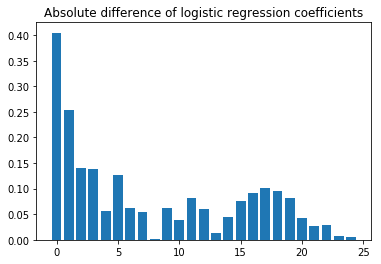

In [46]:
print('Logistic regression coefficients (without sampling): ', betaCoefficients)
hmcCoefficients=np.mean(hmcTheta1, axis=(0,2))
print('sample coefficients: ', hmcCoefficients)
print('absolute difference of the coefficients: ', np.round(abs(betaCoefficients-hmcCoefficients), 2))
height0=abs(betaCoefficients-hmcCoefficients)[0,:]
print(height0.shape)
plt.bar(range(len(height0)),height=height0)
plt.title('Absolute difference of logistic regression coefficients')

### Comparison of the coefficients to regression coefficients calculated with stan

Sampled coefficients and stan coefficients have the same sign, but the sampled coefficients are closer to zero. Same phenomenon is in place when sampled coefficients are compared to the frequentist version of logistic regression.

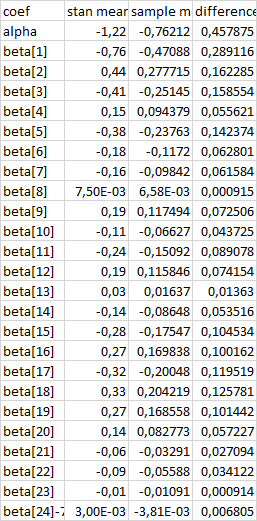

## NUTS sampler 

In [35]:
import LikelihoodFunctions
import ChainMix
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)
importlib.reload(LikelihoodFunctions)
# Reload noUturnSampler-script always anew.
import noUturnSampler
import importlib
importlib.reload(noUturnSampler)
np.seterr('warn')
npr.seed(42)

lBayesLRX=lambda theta0: LikelihoodFunctions.lBayesLR(theta0, creditX, creditY)

# Sample size*2 (only the latter half is returned)
size=1000
nutsTheta0=np.empty([size//2, 25, 4])

# Print debugging info
testRun=False

# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(25)
thetaOriginal2=npr.normal(-1.0, 1.0, 25)
thetaOriginal3=npr.normal(1.0, 1.0, 25)
thetaOriginal4=npr.normal(0.0, 5.0, 25)

nutsTheta0[:,:,0], nutsEpsilon1 = noUturnSampler.NoUTurn(thetaOriginal1, 0.6, lBayesLRX, size,size//2, testRun)
nutsTheta0[:,:,1], nutsEpsilon2 = noUturnSampler.NoUTurn(thetaOriginal2, 0.6, lBayesLRX, size,size//2, testRun)
nutsTheta0[:,:,2], nutsEpsilon3 = noUturnSampler.NoUTurn(thetaOriginal3, 0.6, lBayesLRX, size,size//2, testRun)
nutsTheta0[:,:,3], nutsEpsilon4 = noUturnSampler.NoUTurn(thetaOriginal4, 0.6, lBayesLRX, size,size//2, testRun)

U-Turn sampler finished.


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: underflow encountered in exp
  return f_raw(*args, **kwargs)


U-Turn sampler finished.
U-Turn sampler finished.
U-Turn sampler finished.


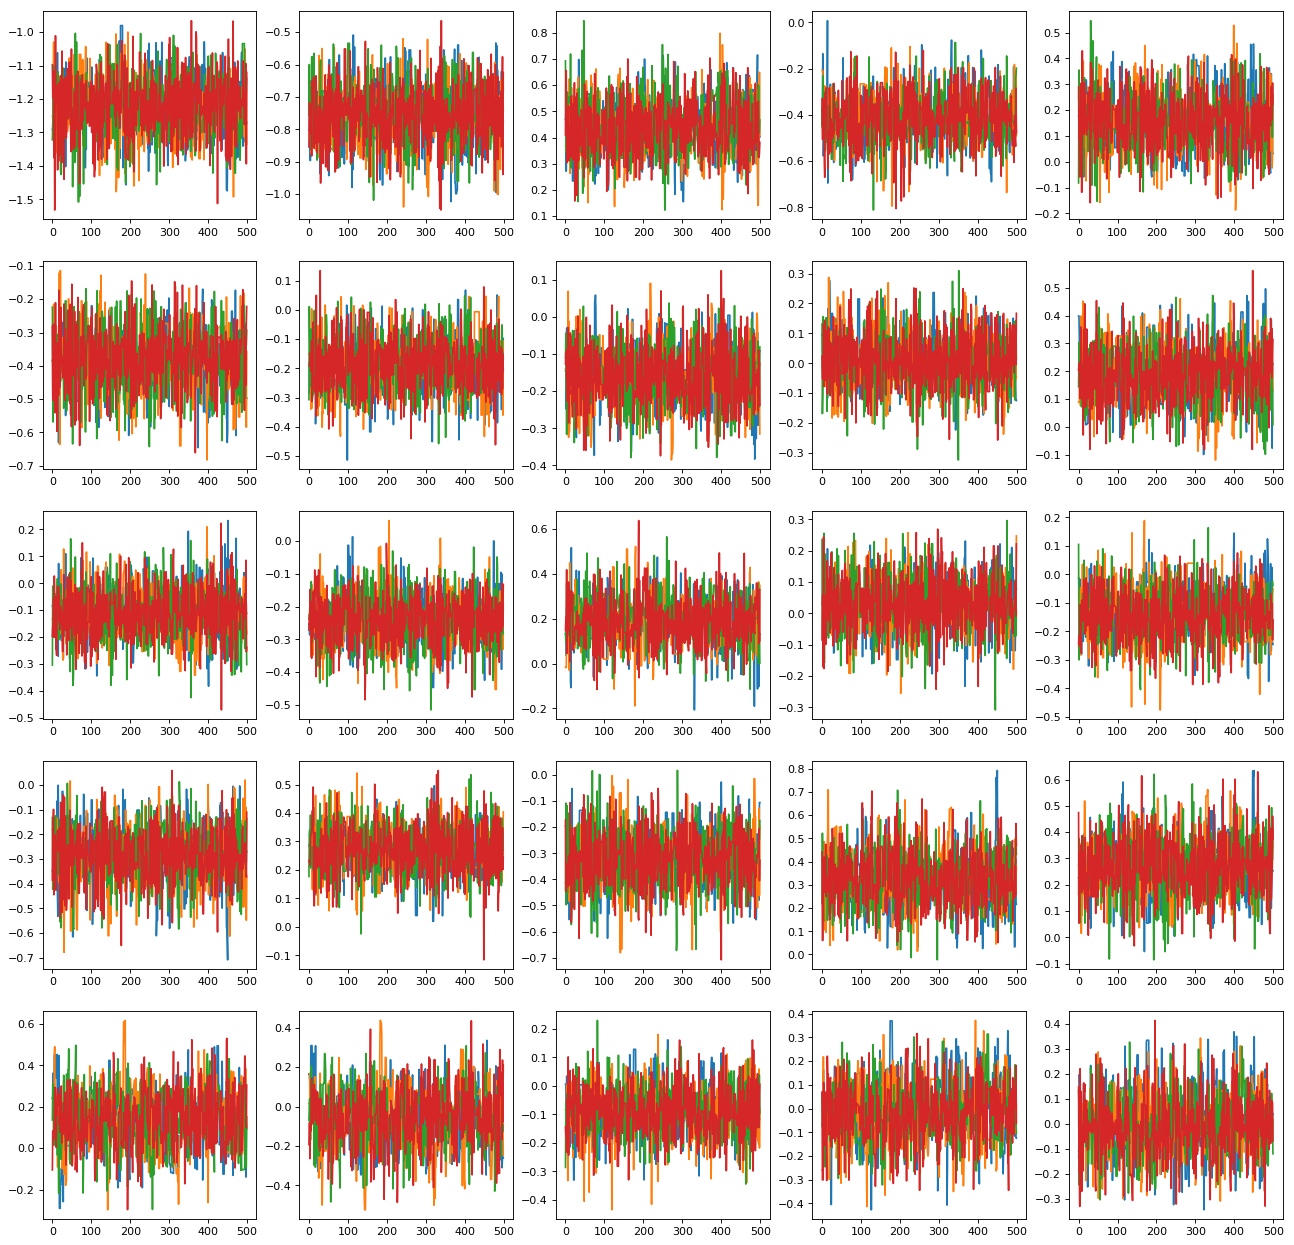

In [36]:
# Plot the 25 samples
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for i in range(nutsTheta0.shape[1]):
    plt.subplot(5,5,i+1)
    plt.plot(nutsTheta0[:, i, :])

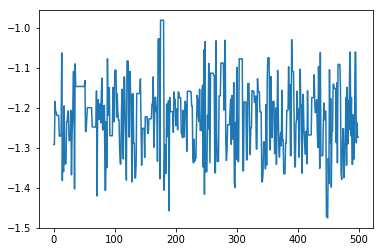

In [37]:
plt.plot(nutsTheta0[:,0,0])

### NUTS: Chain mixing

Same conclusions as with the HMC sample.

RHat statistics for the parameters are:  [8.69933042 5.61622371 2.955042   2.70757108 1.38329951 2.81923513
 1.68288714 1.61818338 1.00643865 1.60857882 1.2627104  2.26740214
 1.53353131 1.02423598 1.39150969 1.88476828 2.24697477 2.15487092
 2.00232493 1.87004333 1.20393001 1.03140101 1.20121322 1.01438275
 1.0054053 ]
vt0 (250, 25, 8)
tt (250,)
Effective sample size:  [  4.04425932   4.12292511   4.47858633   4.60781682   7.8970712
   4.53441846   6.07766179   6.49089866 244.08055656   6.31945536
  10.55501023   4.92858453   6.86455293  49.66687768   7.97492062
   5.3550045    4.96708714   4.97598175   5.30233502   5.65734664
  12.33101102  54.61416279  13.02037668  64.6821954  364.1705611 ]


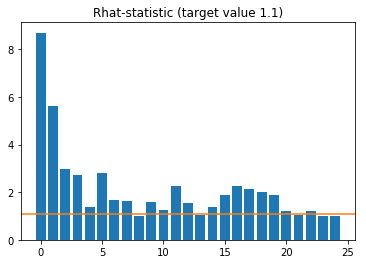

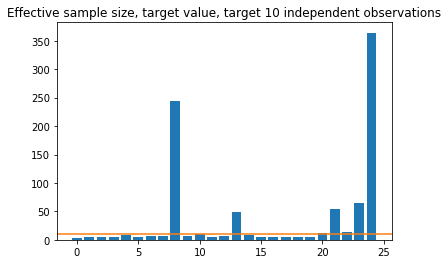

In [38]:
import ConvergenceTests
%matplotlib inline
nutsTheta1=ConvergenceTests.ConvergenceTest(nutsTheta0)

### NUTS: comparison of the regression coefficients

Logistic regression coefficients (without sampling):  [[-1.16693394 -0.72428117  0.41863996 -0.38950509  0.14971296 -0.36499316
  -0.17983097 -0.15223281  0.0088167   0.17896626 -0.10547967 -0.23223442
   0.1752658   0.02906784 -0.13173154 -0.25096542  0.26151383 -0.3013166
   0.29946551  0.24939256  0.12501634 -0.06082535 -0.08394011 -0.01848919
  -0.00851217]]
sample coefficients:  [-0.76238611 -0.46921076  0.27525755 -0.26070301  0.09612272 -0.23659184
 -0.11898711 -0.09902702  0.00803179  0.12065846 -0.06890825 -0.14789512
  0.11894973  0.01878498 -0.08743103 -0.17493989  0.167924   -0.19967525
  0.20053039  0.16869567  0.08881695 -0.03213947 -0.05638992 -0.01037869
 -0.00481214]
absolute difference of the coefficients:  [[0.4  0.26 0.14 0.13 0.05 0.13 0.06 0.05 0.   0.06 0.04 0.08 0.06 0.01
  0.04 0.08 0.09 0.1  0.1  0.08 0.04 0.03 0.03 0.01 0.  ]]
(25,)


Text(0.5,1,'Absolute difference of logistic regression coefficients')

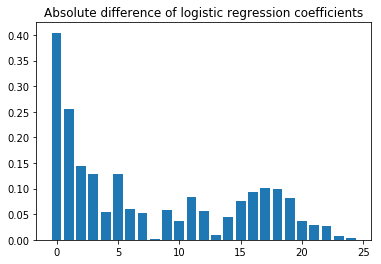

In [39]:
print('Logistic regression coefficients (without sampling): ', betaCoefficients)
nutsCoefficients=np.mean(nutsTheta1, axis=(0,2))
print('sample coefficients: ', nutsCoefficients)
print('absolute difference of the coefficients: ', np.round(abs(betaCoefficients-nutsCoefficients), 2))
height0=abs(betaCoefficients-nutsCoefficients)[0,:]
print(height0.shape)
plt.bar(range(len(height0)),height=height0)
plt.title('Absolute difference of logistic regression coefficients')
#[[0.4  0.25 0.15 0.13 0.05 0.12 0.06 0.05 0.   0.06 0.04 0.08 0.06 0.01
# 0.05 0.07 0.09 0.1  0.09 0.08 0.04 0.02 0.03 0.01 0.01]]

### Comparison of NUTS-sample to HMC-sample and Stan-sample
Interestingly NUTS and HMC coefficients have converged to same values. This suggests that maybe the definitions of the target functions differ - for sure the sample target function has been capped in an arbitrary way to avoid overflows and underflows.

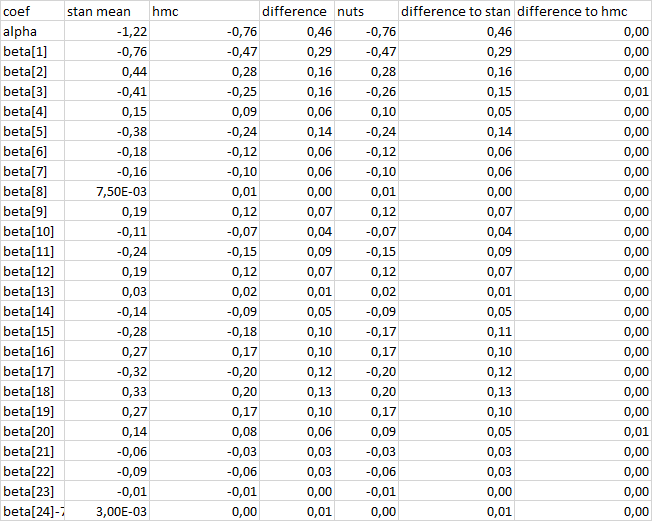

# Test case 3: Hierarchical bayesian logistic regression
* Same data as above, but interaction terms and variance are estimated as well. This leads to 300 parameters.

Here the sampler didn't converge at all, as can be seen in the pictures below. Big challenge was to find step length where the acceptance rate was not 100 % or 0 %, but somewhere around 60 % percent, or even between 40 % and 80 %. (Guidelines taken here: https://pythonhosted.org/pyhmc/tuning.html)

The pictures indicate random walk behaviour, but with a larger step size the acceptance rate drops to zero.

Since the sampler itself is quite simple the likely cause of the problem is the target function, where some suboptimal choices have been made to avoin underflows and overflows.  

In [2]:
#%reset
import autograd.numpy as np
import autograd.numpy.random as npr
# Download data and standardize X
# Should have values 1 or -1
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import HMC
import noUturnSampler
import ChainMix
import Neff
import ConvergenceTests
import LikelihoodFunctions
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)
importlib.reload(ConvergenceTests)
importlib.reload(LikelihoodFunctions)
np.seterr('warn')
credit0= pd.read_csv('dataGerman.tab', delim_whitespace=True)
creditY=np.array(credit0['CREDITRATING'])

creditX0=np.array(credit0.loc[:, credit0.columns != 'CREDITRATING'])
creditX=(creditX0 - np.mean(creditX0, axis=0))/np.std(creditX0, axis=0)

# Create interactions
from sklearn.preprocessing import PolynomialFeatures
hCreditX=PolynomialFeatures(2, interaction_only=True, include_bias=False).fit_transform(creditX)
print('x-vector shape: ', hCreditX.shape)

lBayesHLRX=lambda theta0: LikelihoodFunctions.lBayesHLR(theta0, hCreditX, creditY)

x-vector shape:  (1000, 300)


### HMC

In [ ]:
np.seterr('warn')
importlib.reload(LikelihoodFunctions)
npr.seed(42)

# Calculate 4 chains with dispersed starting points
# Generate vectors as starting values for theta 
# (=300 beta coefficients, 1 alpha and 1 sigma2
lenTheta=hCreditX.shape[1]+2
thetaOriginal1=np.zeros(lenTheta)+0.001
thetaOriginal2=npr.normal(-1.0, 1.0, lenTheta)
thetaOriginal3=npr.normal(1.0, 1.0, lenTheta)
thetaOriginal4=npr.normal(0.0, 1.0, lenTheta)

# Sample size*2 (only the latter half is returned)
size=1000
hmcTheta0=np.empty([size//2, lenTheta, 4])

hmcTheta0[:,:,1], hmcR2 = HMC.basicHmc(thetaOriginal2, 0.0022, 10, lBayesHLRX, size)
hmcTheta0[:,:,2], hmcR3 = HMC.basicHmc(thetaOriginal3, 0.0022, 10, lBayesHLRX, size)
hmcTheta0[:,:,3], hmcR4 = HMC.basicHmc(thetaOriginal4, 0.002, 10, lBayesHLRX, size)
hmcTheta0[:,:,0], hmcR1 = HMC.basicHmc(thetaOriginal1, 0.001, 10, lBayesHLRX, size)

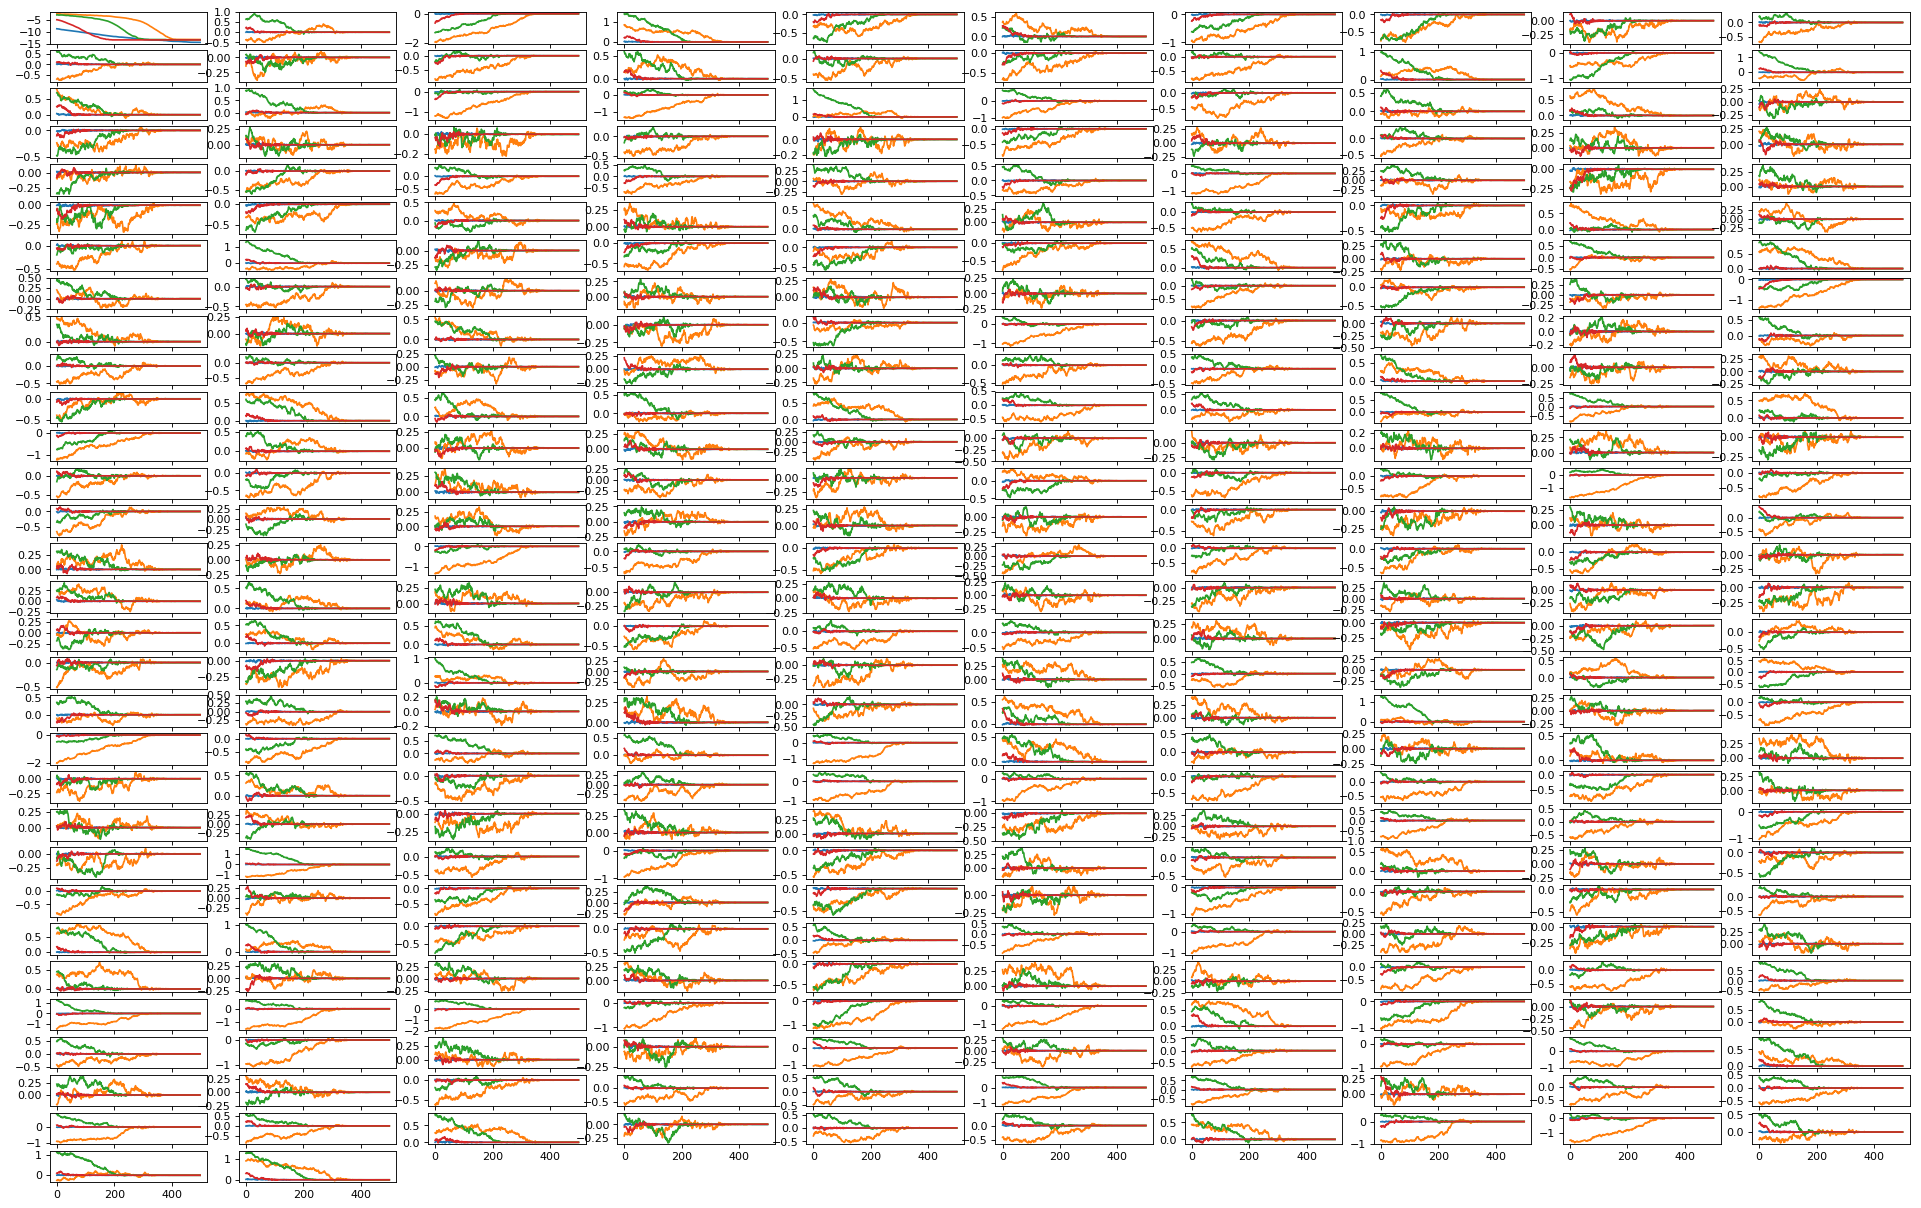

In [62]:
# Plot the 25 samples
fig=plt.figure(figsize=(30, 20), dpi= 80, facecolor='w', edgecolor='k')
for i in range(hmcTheta0.shape[1]):
    plt.subplot(32,10,i+1)
    plt.plot(hmcTheta0[:, i, :])

In [ ]:
ConvergenceTests.ConvergenceTest(hmcTheta0)

### NUTS

In [ ]:
# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(lenTheta)
thetaOriginal2=npr.normal(-2.0, 1.0, lenTheta)
thetaOriginal3=npr.normal(2.0, 1.0, lenTheta)
thetaOriginal4=npr.normal(0.0, 1.0, lenTheta)

# Sample size*2 (only the latter half is returned)
importlib.reload(LikelihoodFunctions)
importlib.reload(noUturnSampler)
np.seterr('warn')
size=1000
nutsTheta0=np.empty([size//2, lenTheta, 4])
nutsTheta0[:,:,0], nutsEpsilon1 = noUturnSampler.NoUTurn(thetaOriginal1, 0.6, lBayesHLRX, size,size//2, testRun=False)
nutsTheta0[:,:,1], nutsEpsilon2 = noUturnSampler.NoUTurn(thetaOriginal2, 0.6, lBayesHLRX, size,size//2, testRun=False)
nutsTheta0[:,:,2], nutsEpsilon3 = noUturnSampler.NoUTurn(thetaOriginal3, 0.6, lBayesHLRX, size,size//2, testRun=False)
nutsTheta0[:,:,3], nutsEpsilon4 = noUturnSampler.NoUTurn(thetaOriginal4, 0.6, lBayesHLRX, size,size//2, testRun=False)

# First parameter is variance, exponentiate it
nutsTheta0[:,0,:]=np.exp(nutsTheta0[:,0,:])

C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: underflow encountered in exp
  return f_raw(*args, **kwargs)


U-Turn sampler finished.


In [ ]:
# Plot the 25 samples
fig=plt.figure(figsize=(30, 20), dpi= 80, facecolor='w', edgecolor='k')
for i in range(nutsTheta0.shape[1]):
    plt.subplot(32,10,i+1)
    plt.plot(nutsTheta0[:, i, :])

In [ ]:
ConvergenceTests.ConvergenceTest(nutsTheta0)


## Test case 1: 250 dimensional multivariate normal

In [ ]:
def fLNormal250(parTheta, matrixA):
    return -1/2*parTheta.T @ matrixA @ parTheta

# Generate 250*250 matrix for multivariate normal-distribution
from scipy.stats import wishart
precisionMatrixA=wishart.rvs(df=250, scale=np.identity(250), random_state=None)
normal250likelihood=lambda x: fLNormal250(x, matrixA=precisionMatrixA)


### HMC

In [ ]:
np.seterr('warn')
npr.seed(42)

# Calculate 4 chains with dispersed starting points
# Generate vectors as starting values for theta 
# (=300 beta coefficients, 1 alpha and 1 sigma2
lenTheta=250
thetaOriginal1=np.zeros(lenTheta)
thetaOriginal2=npr.normal(-1.0, 1.0, lenTheta)
thetaOriginal3=npr.normal(1.0, 1.0, lenTheta)
thetaOriginal4=npr.normal(0.0, 1.0, lenTheta)

# Sample size*2 (only the latter half is returned)
size=500
hmcTheta0=np.empty([size//2, lenTheta, 4])

hmcTheta0[:,:,1], hmcR2 = HMC.basicHmc(thetaOriginal2, 0.001, 10, normal250likelihood, size)
hmcTheta0[:,:,2], hmcR3 = HMC.basicHmc(thetaOriginal3, 0.001, 10, normal250likelihood, size)
hmcTheta0[:,:,3], hmcR4 = HMC.basicHmc(thetaOriginal4, 0.001, 10, normal250likelihood, size)
hmcTheta0[:,:,0], hmcR1 = HMC.basicHmc(thetaOriginal1, 0.001, 10, normal250likelihood, size)

In [ ]:
# Plot the 25 samples
fig=plt.figure(figsize=(30, 20), dpi= 80, facecolor='w', edgecolor='k')
for i in range(hmcTheta0.shape[1]):
    plt.subplot(32,10,i+1)
    plt.plot(hmcTheta0[:, i, :])

In [ ]:
ConvergenceTests.ConvergenceTest(hmcTheta0)

### No-U-Turn sampler

In [ ]:
# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
lenTheta=250
thetaOriginal1=np.zeros(lenTheta)
thetaOriginal2=npr.normal(-2.0, 1.0, lenTheta)
thetaOriginal3=npr.normal(2.0, 1.0, lenTheta)
thetaOriginal4=npr.normal(0.0, 1.0, lenTheta)

# Sample size*2 (only the latter half is returned)
importlib.reload(LikelihoodFunctions)
importlib.reload(noUturnSampler)
np.seterr('warn')
size=2000
nutsTheta0=np.empty([size//2, lenTheta, 4])
nutsTheta0[:,:,0], nutsEpsilon1 = noUturnSampler.NoUTurn(thetaOriginal1, 0.6, normal250likelihood, size,size//2, testRun=False)
nutsTheta0[:,:,1], nutsEpsilon2 = noUturnSampler.NoUTurn(thetaOriginal2, 0.6, normal250likelihood, size,size//2, testRun=False)
nutsTheta0[:,:,2], nutsEpsilon3 = noUturnSampler.NoUTurn(thetaOriginal3, 0.6, normal250likelihood, size,size//2, testRun=False)
nutsTheta0[:,:,3], nutsEpsilon4 = noUturnSampler.NoUTurn(thetaOriginal4, 0.6, normal250likelihood, size,size//2, testRun=False)

In [ ]:
# Plot the 250 samples
fig=plt.figure(figsize=(30, 20), dpi= 80, facecolor='w', edgecolor='k')
for i in range(nutsTheta0.shape[1]):
    plt.subplot(25,10,i+1)
    plt.plot(nutsTheta0[:, i, :])

In [ ]:
ConvergenceTests.ConvergenceTest(nutsTheta0)